# PSS-78 based Salinity Calculation - Uncalibrated, Micro Siemens

3.2.2.1 formula is the best for calculating salinity (?)

(And the input Ye (electrical conductivity) should be in milliSiemens rather than microSiemens)

And then the non-linear temperature coefficient is applied as described below from Section 4 of the "Conductivity Assistant" Improvements document.


Conductivity Assistant Data Processing Flow for sea water.

 4.1. Select Range.

 4.2. Read Conductivity and Temperature points
 
 4.3. Calculate preliminary Salinity using PSS-78 for each point.  

USE formula 3.2.2.1 to calculate salinity from conductivity and temp

4.4. Calculate Temperature Coefficient using the TC equation (Taylor Series) with Salinity and Temperature for each point. 

4.5. Calculate Specific Conductance using the Temperature Coefficient for each point.

THIS CAN BE DONE USING formula 3.2.2.3, applied the calculated Temperature Coefficient

 4.6. If selected, calculate the hand-held meter Specific Conductance points. 

4.7. If selected, adjust the Specific Conductance dataset of the logger per the calibration data. Output Specific Conductance. 

4.8. Calculate final Salinity using the specific conductance dataset at 25 OC in PSS-78. Output Salinity


### Reading the data import pandas as pd
File Name: RB1_ConDL_6_9_2023_AH.csv

Removing the first 8 rows because they're empty and doing some basic cleaning to make it more pliable. This would ideally be done in a more robust, generalizable manner once we validate this process.

In [26]:
import pandas as pd


con_data = pd.read_csv('/Users/christina/scc_db/data/RB1_ConDL_6_9_2023_AH.csv')


In [21]:
con_data = con_data.iloc[7:-2, :-2] # remove the first 7 and last 2 rows and last 2 columns


In [23]:
con_data

,#,"Date Time, GMT-04:00",LowRange,HighRange,temp
7,8,06/02/23 11:10:00 AM,33594.4,30064.6,22.22
8,9,06/02/23 11:20:00 AM,33594.4,30697.7,21.81
9,10,06/02/23 11:30:00 AM,33594.4,30687.6,21.70
10,11,06/02/23 11:40:00 AM,33594.4,30685.1,21.73
11,12,06/02/23 11:50:00 AM,33594.4,30712.8,21.73
...,...,...,...,...,...
1020,1021,06/09/23 12:00:00 PM,33594.4,30198.6,18.51
1021,1022,06/09/23 12:10:00 PM,33594.4,30215.7,18.53
1022,1023,06/09/23 12:20:00 PM,33594.4,30215.7,18.51
1023,1024,06/09/23 12:30:00 PM,33594.4,30208.4,18.54


### Formulas extracted from Paul's sheet

 3.2.2 Calculate Specific Conductance at 25 C (Cs) using the second option of Seawater Compensation:

  3.2.2.1 Calculate Salinity using:
  
        Ye = Electrical Conductivity
        
        T = water temperature in degrees C


Ye for electrical conductivity (in microSiemens, converted to milliSiemens in the code).

T for temperature.

S for salinity.

a for the temperature coefficient.

Cs for specific conductance.

Rt, Rt_sqrt, and Rt_powers for the various powers of Rt used in the salinity calculation.


In [25]:
import numpy as np

# TODO: Check the constants against the ones in the paper
a_coeffs = [0.008, -0.1692, 25.3851, 14.0941, -7.0261, 2.7081]
b_coeffs = [0.0005, -0.0056, -0.0066, -0.0375, 0.0636, -0.0144]
c_coeffs = [6.766097e-01, 2.00564e-02, 1.104259e-04, -6.9698e-07, 1.0031e-09]
k = 0.0162
R_factor = 42.914

pss78_A = 1.86221444
pss78_B = 7.9914178e-03
pss78_C = -2.0488276e-03
pss78_D = -4.79386353e-05
pss78_E = 1.67997158e-05
pss78_F = -1.55721008e-05

def calculate_salinity(Ye, T):
    Ye_mS = Ye / 1000.0  # Convert to milliSiemens
    Ye_mS = max(Ye_mS, 0.0)  # Ensure non-negative

    T_factor = (T - 15.0) / (1.0 + k * (T - 15.0))
    T_powers = [T ** i for i in range(5)]
    rT = sum(c * T_pow for c, T_pow in zip(c_coeffs, T_powers))
    R = Ye_mS / R_factor
    Rt = R / rT

    # Rt_sqrt = np.sqrt(Rt)
    Rt_powers = [Rt ** (i / 2) for i in range(1, 6)]

    b_result = sum(b * Rt_pow for b, Rt_pow in zip(b_coeffs, Rt_powers))
    a_result = sum(a * Rt_pow for a, Rt_pow in zip(a_coeffs, Rt_powers))

    return a_result + T_factor * b_result

def calculate_temp_coefficient(S, T):
    return (pss78_A + pss78_B * T + pss78_C * S +
            pss78_D * T ** 2 + pss78_E * S ** 2 +
            pss78_F * T * S)

def calculate_specific_conductance(Ye, T, a):
    return Ye / (1 - ((25 - T) * a / 100))

# Example usage from row #9 in RB1_ConDL_6_9_2023_AH.csv
T = 21.81  # from temp column
Ye = 30697.7  # from HighRange column

S = calculate_salinity(Ye, T)
a = calculate_temp_coefficient(S, T)
Cs = calculate_specific_conductance(Ye, T, a)

print(f"Salinity: {S} ppt")
print(f"Specific Conductance: {Cs} S/m")


Salinity: 15.455914525563147 ppt
Specific Conductance: 32768.24569153949 S/m


# Compare against Hoboware data factory calibrated

In [33]:
# Raw data
con_data = pd.read_csv('/Users/christina/scc_db/data/RB1_ConDL_6_9_2023_AH.csv')
con_data = con_data.iloc[:, :-2] # remove the last 2 columns

In [34]:
con_data.drop(columns=['LowRange'], inplace=True)

In [35]:
con_data

,#,"Date Time, GMT-04:00",HighRange,temp
0,1,06/02/23 10:00:00 AM,0.0,24.38
1,2,06/02/23 10:10:00 AM,0.0,24.84
2,3,06/02/23 10:20:00 AM,0.0,25.20
3,4,06/02/23 10:30:00 AM,0.0,26.51
4,5,06/02/23 10:40:00 AM,0.0,26.41
...,...,...,...,...
1022,1023,06/09/23 12:20:00 PM,30215.7,18.51
1023,1024,06/09/23 12:30:00 PM,30208.4,18.54
1024,1025,06/09/23 12:40:00 PM,29924.4,19.14
1025,1026,06/09/23 12:44:21 PM,NaN,NaN


In [36]:
# Hoboware data
hobo_data = pd.read_csv('/Users/christina/scc_db/data/Salinity-Output-Check-6-9-2023.csv')

In [37]:
hobo_data

,Date Time,HighRange,temp,Specific Conductance.factory.calibration (μS/cm),Salinity.factory.calibration (ppt)
0,06/02/23 11:00:00.000,0.0,24.38,0.000000,0.012303
1,06/02/23 11:10:00.000,0.0,24.84,0.000000,0.012303
2,06/02/23 11:20:00.000,0.0,25.20,0.000000,0.012303
3,06/02/23 11:30:00.000,0.0,26.51,0.000000,0.012303
4,06/02/23 11:40:00.000,0.0,26.41,0.000000,0.012303
...,...,...,...,...,...
1021,06/09/23 13:10:00.000,30215.7,18.53,34580.799870,21.721791
1022,06/09/23 13:20:00.000,30215.7,18.51,34595.903904,21.732272
1023,06/09/23 13:30:00.000,30208.4,18.54,34564.922940,21.710774
1024,06/09/23 13:40:00.000,29924.4,19.14,33797.176074,21.178850


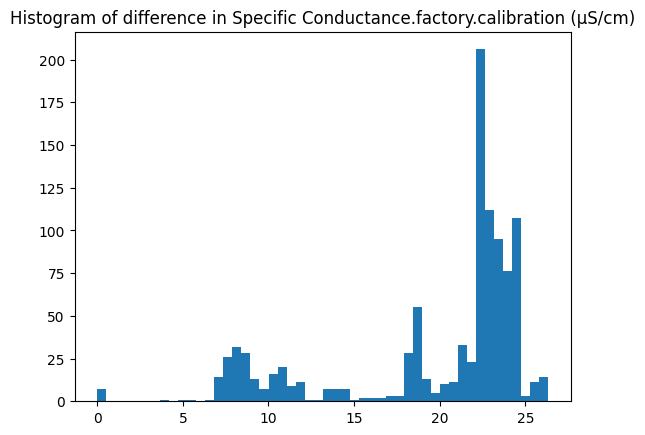

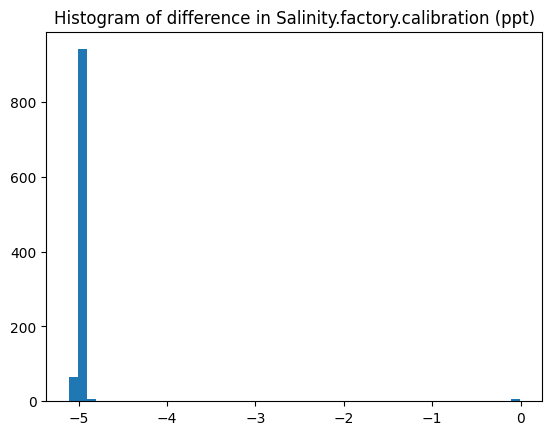

In [54]:
import matplotlib.pyplot as plt

diff = con_data["Specific Conductance.factory.calibration (μS/cm)"] - hobo_data["Specific Conductance.factory.calibration (μS/cm)"]
plt.hist(diff.dropna(), bins=50)
plt.title('Histogram of difference in Specific Conductance.factory.calibration (μS/cm)')
plt.show()
diff_salinity = con_data["Salinity.factory.calibration (ppt)"] - hobo_data["Salinity.factory.calibration (ppt)"]
plt.hist(diff_salinity.dropna(), bins=50)
plt.title('Histogram of difference in Salinity.factory.calibration (ppt)')
plt.show()


In [38]:
# Apply the formulas to the entire DataFrame
con_data['Salinity.factory.calibration (ppt)'] = con_data.apply(lambda row: calculate_salinity(row['HighRange'], row['temp']), axis=1)
con_data['Specific Conductance.factory.calibration (μS/cm)'] = con_data.apply(lambda row: calculate_specific_conductance(row['HighRange'], row['temp'], calculate_temp_coefficient(row['Salinity.factory.calibration (ppt)'], row['temp'])), axis=1)



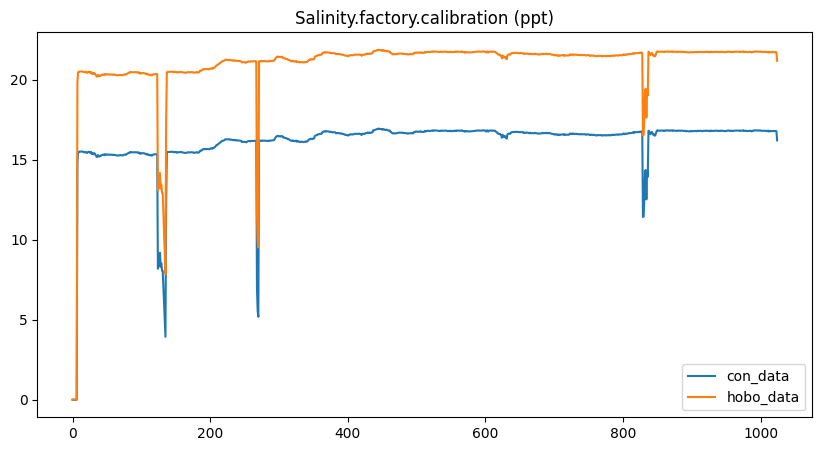

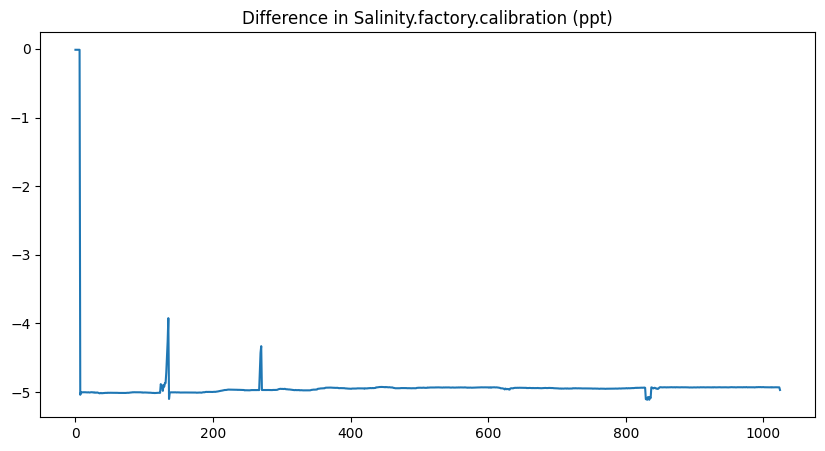

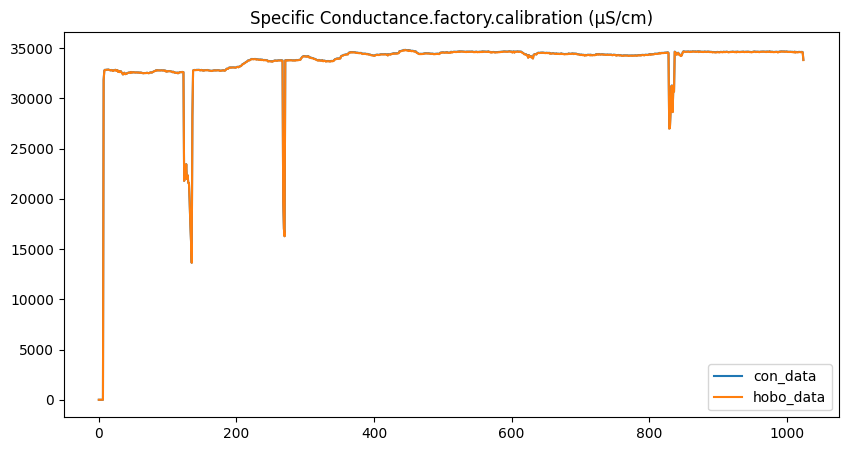

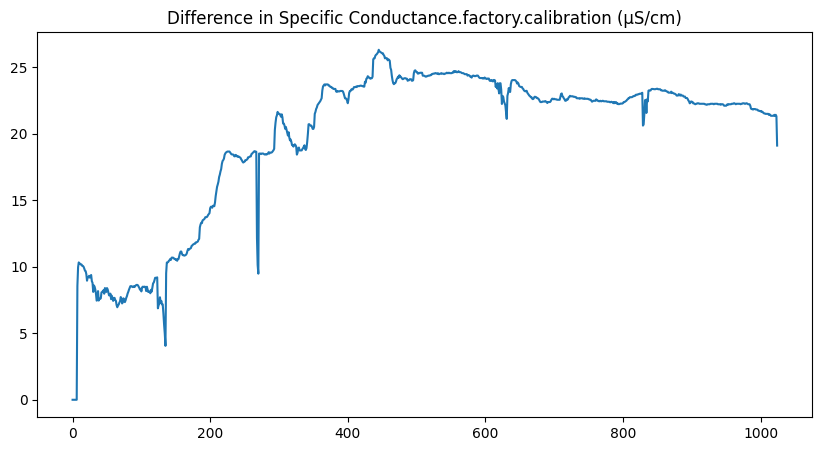

In [43]:
import matplotlib.pyplot as plt

# Plot Salinity.factory.calibration (ppt)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Salinity.factory.calibration (ppt)'], label='con_data')
plt.plot(hobo_data['Salinity.factory.calibration (ppt)'], label='hobo_data')
plt.title('Salinity.factory.calibration (ppt)')
plt.legend()
plt.show()

# Plot difference in Salinity.factory.calibration (ppt)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Salinity.factory.calibration (ppt)'] - hobo_data['Salinity.factory.calibration (ppt)'])
plt.title('Difference in Salinity.factory.calibration (ppt)')
plt.show()

# Plot Specific Conductance.factory.calibration (μS/cm)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Specific Conductance.factory.calibration (μS/cm)'], label='con_data')
plt.plot(hobo_data['Specific Conductance.factory.calibration (μS/cm)'], label='hobo_data')
plt.title('Specific Conductance.factory.calibration (μS/cm)')
plt.legend()
plt.show()

# Plot difference in Specific Conductance.factory.calibration (μS/cm)
plt.figure(figsize=(10, 5))
plt.plot(con_data['Specific Conductance.factory.calibration (μS/cm)'] - hobo_data['Specific Conductance.factory.calibration (μS/cm)'])
plt.title('Difference in Specific Conductance.factory.calibration (μS/cm)')
plt.show()
